In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyoff
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Etapa de Pre-processamento

In [4]:
ratings = pd.read_csv('dataset/BX-Book-Ratings.csv', encoding='ISO-8859-1', delimiter=';')
books = pd.read_csv('dataset/BX-Books.csv', encoding='ISO-8859-1', delimiter=';', error_bad_lines=False)
users = pd.read_csv('dataset/BX-Users.csv', encoding='ISO-8859-1', delimiter=';')

b'Skipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [5]:
books = books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


(array([716109.,   1770.,   2759.,   5996.,   8904.,  50974.,  36924.,
         76457., 103736., 146151.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

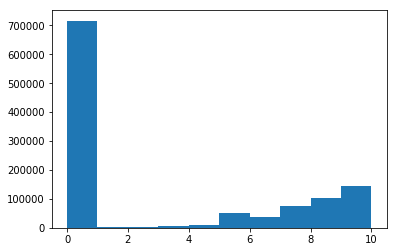

In [7]:
# Distribuição dos Ratings
plt.hist(ratings['Book-Rating'])

In [8]:
book_rating = pd.merge(ratings, books, on='ISBN', how='inner')

In [9]:
book_rating.shape

(1031141, 7)

In [10]:
book_rating = pd.merge(book_rating,users, on='User-ID', how='inner')

In [11]:
book_rating.shape

(1031141, 9)

In [12]:
book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,"cincinnati, ohio, usa",23.0


Removendo todos os ratings iguais a zero e usuários que avaliaram menos de 4 vezes, com o intuito de criar uma matrix menos esparça

In [13]:
book_rating = book_rating[book_rating['Book-Rating']> 0]
book_rating.shape

(383844, 9)

In [14]:
book_rating.groupby('ISBN')['User-ID'].count().describe()

count    149837.000000
mean          2.561744
std           7.505537
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: User-ID, dtype: float64

In [15]:
# filtrando apenas os livros que foram avaliados mais de 10 vezes
ratings_full = book_rating.groupby('ISBN').filter(lambda x: len(x) >= 10)

In [16]:
ratings_full.shape

(139296, 9)

In [17]:
ratings_full = ratings_full.groupby('User-ID').filter(lambda x: len(x) >= 4)

In [18]:
ratings_full.shape

(96297, 9)

In [19]:
ratings_full = ratings_full.groupby(['ISBN', 'User-ID'])['Book-Rating'].mean().to_frame().reset_index()

In [20]:
ratings_full.head()

,ISBN,User-ID,Book-Rating
0,0002558122,11676,8
1,0002558122,81274,8
2,0002558122,201537,8
3,000648302X,11676,8
4,000648302X,37950,9


Persistindo a base processada

In [22]:
ratings_full.to_csv('dataset/ratings_full.csv')

# Treinamento dos modelos

Logo abaixo será construida a classe de avaliação do modelo com as métricas de precisão Top-N, que avalia a precisão das principais recomendações fornecidas ao usuário, comparando com os itens com os quais ele realmente interagiu no conjunto de testes.
Este método de avaliação funciona da seguinte maneira:

* Para cada usuário
    * Para cada item que o usuário interagiu no conjunto de testes
        * Calcule as métricas de precisão Top-N para este usuário e o item interagido na lista de classificação das recomendações
* Agregue as métricas globais de precisão Top-N

In [23]:
ratings_train, ratings_test = train_test_split(ratings_full,test_size=0.20,stratify=ratings_full['User-ID'], random_state=42)

print('# avaliações de treino: %d' % len(ratings_train))
print('# avaliações no teste: %d' % len(ratings_test))

# avaliações de treino: 77037
# avaliações no teste: 19260


In [24]:
ratings_full_index = ratings_full.set_index('User-ID')
ratings_test_index = ratings_test.set_index('User-ID')
ratings_train_index = ratings_train.set_index('User-ID')

In [25]:
class AvaliacaoModelo:

    def retorna_itens_avaliados(self, user_id, ratings):
        # Obter os dados do usuário e mesclar as informações do filme.
        itens_avaliados = ratings.loc[user_id]['ISBN']
        return set(itens_avaliados if type(itens_avaliados) == pd.Series else [itens_avaliados])

    def _verify_hit_top_n(self, item_id, itens_recomendados, topn):        
        try:
            index = next(i for i, c in enumerate(itens_recomendados) if c == item_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def avaliar_modelo_usuario(self, model, user_id):
        #Colocando os Itens no Conjunto de Teste
        itens_avaliados_teste = ratings_test_index.loc[user_id]
        if type(itens_avaliados_teste['ISBN']) == pd.Series:
            user_itens_avaliados_test = set(itens_avaliados_teste['ISBN'])
        else:
            user_itens_avaliados_test = set([itens_avaliados_teste['ISBN']])  
        itens_avaliados_count_test = len(user_itens_avaliados_test)

        #Obtendo uma lista de recomendações classificadas de um modelo para um determinado usuário
        user_recs_df = model.recomenda_itens(user_id,items_to_ignore=self.retorna_itens_avaliados(user_id, 
                                                                                            ratings_train_index), 
                                               topn=100)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #Para cada item que o usuário avaliou no conjunto de testes
        for item_id in user_itens_avaliados_test:
                                                   
            valid_recs = user_recs_df['ISBN'].values
            #Verificando se o item classificado atual está entre os top-N itens recomendados
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall é a taxa dos itens avaliados classificados entre os Top-N itens recomendados, 
        #quando misturado com um conjunto de itens não relevantes
        recall_at_5 = hits_at_5_count / float(itens_avaliados_count_test)
        recall_at_10 = hits_at_10_count / float(itens_avaliados_count_test)

        user_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'avaliacoes_count': itens_avaliados_count_test,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

    def avaliar_modelo(self, model):
        people_metrics = []
        #with tqdm(total=len(ratings_test_index.index.unique().values)) as pbar:
        for idx, user_id in enumerate(list(ratings_test_index.index.unique().values)):
            user_metrics = self.avaliar_modelo_usuario(model, user_id)  
            user_metrics['_user_id'] = user_id
            people_metrics.append(user_metrics)
                #pbar.write('%d users processed' % idx)
                #pbar.update(1)
        print('%d usuários processados' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('avaliacoes_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['avaliacoes_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['avaliacoes_count'].sum())

        global_metrics = {'modelName': model.retorna_nome_modelo(),
                            'recall@5': global_recall_at_5,
                            'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
avaliacao_modelo = AvaliacaoModelo()

## Modelo de popularidade

In [26]:
#itens mais bem avaliados
itens_populares = ratings_full.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False).reset_index()
itens_populares.head(10)

,ISBN,Book-Rating
0,8845247414,10.0
1,0618260250,10.0
2,8817131628,10.0
3,159184021X,10.0
4,0552133256,10.0
5,1888054557,10.0
6,2070388905,10.0
7,3404149114,10.0
8,3442760003,10.0
9,3453146972,10.0


In [27]:
class PopularityRecommender:
    
    NOME_MODELO = 'Popularidade'
    
    def __init__(self, popularidade_df, itens_df=None):
        self.popularidade_df = popularidade_df
        self.itens_df = itens_df
        
    def retorna_nome_modelo(self):
        return self.NOME_MODELO
        
    def recomenda_itens(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recomemda os itens mais populares que os usuários não viram ainda
        recomendacoes_df = self.popularidade_df[~self.popularidade_df['ISBN'].isin(items_to_ignore)] \
                               .sort_values('Book-Rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.itens_df is None:
                raise Exception('"itens_df" is required in verbose mode')

            recomendacoes_df = recomendacoes_df.merge(self.itens_df, how = 'left', 
                                                        left_on = 'ISBN', 
                                                        right_on = 'ISBN')[['Book-Rating', 'ISBN', 'Book-Title', 'Book-Author']]


        return recomendacoes_df
    
modelo_popularidade = PopularityRecommender(itens_populares, book_rating)

In [28]:
# Testando o modelo
modelo_popularidade.recomenda_itens(user_id=79089,
                                    items_to_ignore=avaliacao_modelo.retorna_itens_avaliados(user_id=79089,ratings=ratings_train_index),
                                    topn=10)

,ISBN,Book-Rating
0,8845247414,10.0
6,2070388905,10.0
10,3551551693,10.0
9,3453146972,10.0
8,3442760003,10.0
7,3404149114,10.0
1,0618260250,10.0
5,1888054557,10.0
2,8817131628,10.0
4,0552133256,10.0


In [29]:
print('Avaliando modelo de popularidade...')
pop_global_metrics, pop_detailed_results_df = avaliacao_modelo.avaliar_modelo(modelo_popularidade)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Avaliando modelo de popularidade...
7460 usuários processados

Global metrics:
{'modelName': 'Popularidade', 'recall@5': 5.1921079958463136e-05, 'recall@10': 0.00015576323987538941}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
53,11676,379,0,0,0.0,0.0
102,16795,68,0,0,0.0,0.0
248,98391,63,0,0,0.0,0.0
95,153662,60,0,0,0.0,0.0
79,95359,57,0,0,0.0,0.0
189,104636,54,0,0,0.0,0.0
143,114368,53,0,0,0.0,0.0
658,123883,41,0,0,0.0,0.0
604,60244,41,0,0,0.0,0.0
222,158295,40,0,0,0.0,0.0


# Modelo de filtros colaborativos

In [30]:
def prepare_matrix(ratings):
    #Criando uma tabela dinâmica esparsa com usuários em linhas e itens em colunas
    users_books_pivot_matrix_df = ratings.pivot(index='User-ID',columns='ISBN',values='Book-Rating').fillna(0)
    users_books_pivot_matrix = users_books_pivot_matrix_df.values
    users_ids = list(users_books_pivot_matrix_df.index)
    columns = users_books_pivot_matrix_df.columns
    return users_books_pivot_matrix, users_ids, columns

In [31]:
users_books_pivot_matrix, users_ids, columns = prepare_matrix(ratings_train)

In [32]:
# Calculando a esparsidade da matriz
# Esse resultado significa que temos apenas 0,19% de ratings neste conjunto de dados e que todo o 
# resto está preenchido com zeros (esses zeros NÃO representam ratings e sim valores missing)
sparsity = float(len(users_books_pivot_matrix.nonzero()[0]))
sparsity /= (users_books_pivot_matrix.shape[0] * users_books_pivot_matrix.shape[1])
sparsity *= 100 
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.19%


In [33]:
# Calculando a matriz de distâncias com: cosine_distances(ratings_train)
users_books_pivot_sparse_matrix_dist = 1 - cosine_distances(users_books_pivot_matrix)

In [34]:
# Prevendo os ratings
# Isso é feito através da multiplicação da matriz de distâncias com a matriz de ratings
user_pred = users_books_pivot_sparse_matrix_dist.dot(users_books_pivot_matrix) / np.array([np.abs(users_books_pivot_sparse_matrix_dist).sum(axis=1)]).T

In [35]:
#Convertendo a matriz reconstruída em um dataframe do Pandas
cf_user_preds_df = pd.DataFrame(user_pred, columns = columns, index=users_ids).transpose()
cf_user_preds_df.head(10)

,114,243,244,254,383,388,487,503,505,507,...,278243,278314,278356,278390,278418,278535,278554,278582,278633,278843
ISBN,,,,,,,,,,,,,,,,,,,,,
0002558122,0.000000,0.000000,0.035226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.030832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000648302X,0.003398,0.004848,0.010967,0.010167,0.047955,0.009699,0.026236,0.006071,0.004158,0.016202,...,0.000000,0.018778,0.008986,0.003381,0.069164,0.012440,0.004070,0.002130,0.016340,0.006903
000649840X,0.105666,0.009411,0.010967,0.004148,0.047955,0.009699,0.026236,0.006071,0.004158,0.006864,...,0.020554,0.018778,0.008986,0.070905,0.025604,0.012440,0.004070,0.010033,0.043843,0.014548
0006547834,0.002124,0.003030,0.006854,0.002593,0.029972,0.006062,0.016397,0.050386,0.002599,0.004290,...,0.018906,0.011736,0.005616,0.002113,0.016002,0.007775,0.055021,0.001331,0.008752,0.004314
0006550576,0.000000,0.000000,0.000000,0.005173,0.000000,0.000000,0.000000,0.000000,0.000000,0.024175,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015787,0.000000
0006550789,0.002974,0.015399,0.009596,0.011362,0.041961,0.008486,0.022956,0.005312,0.003639,0.006006,...,0.017811,0.016431,0.016512,0.002958,0.022403,0.010885,0.003562,0.001864,0.020407,0.006040
0007110928,0.002974,0.008640,0.017957,0.014374,0.041961,0.029890,0.022956,0.030264,0.003639,0.006006,...,0.013396,0.016431,0.007863,0.002958,0.034908,0.027474,0.003562,0.001864,0.020607,0.011894
0007154615,0.002974,0.024789,0.016103,0.010210,0.041961,0.008486,0.022956,0.058019,0.003639,0.012614,...,0.000000,0.016431,0.021434,0.002958,0.038291,0.010885,0.043952,0.050692,0.007387,0.031728
000716226X,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041414,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046646,0.000000,0.000000,0.000000


In [36]:
class CFRecommender:
    
    MODEL_NAME = 'Filtros Colaborativos'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def retorna_nome_modelo(self):
        return self.MODEL_NAME
        
    def recomenda_itens(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Obter e classificar as previsões do usuário
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'Book-Rating'})

        # Recomende os livros com a classificação mais alta prevista que o usuário ainda não leu.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)] \
                               .sort_values('Book-Rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ISBN', 
                                                          right_on = 'ISBN')[['Book-Rating', 'ISBN', 'Book-Title', 'Book-Author']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_user_preds_df, ratings_full)

In [37]:
print('Avaliando modelo de filtros colaborativos...')
cf_global_metrics, cf_detailed_results_df = avaliacao_modelo.avaliar_modelo(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Avaliando modelo de filtros colaborativos...
7460 usuários processados

Global metrics:
{'modelName': 'Filtros Colaborativos', 'recall@5': 0.05893042575285566, 'recall@10': 0.08452751817237798}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
53,11676,379,2,1,0.005277,0.002639
102,16795,68,1,1,0.014706,0.014706
248,98391,63,1,0,0.015873,0.000000
95,153662,60,1,1,0.016667,0.016667
79,95359,57,2,2,0.035088,0.035088
189,104636,54,3,1,0.055556,0.018519
143,114368,53,2,1,0.037736,0.018868
658,123883,41,4,2,0.097561,0.048780
604,60244,41,0,0,0.000000,0.000000
222,158295,40,1,1,0.025000,0.025000


In [38]:
#Função que retorna a taxa de erros do modelo
def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [39]:
ratings_matrix_test, user_id_test, columns_test = prepare_matrix(ratings_test)

In [40]:
ratings_matrix_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
# Extraindo a taxa de erros do modelo.
get_mse(user_pred, ratings_matrix_test)

63.990744794806844

# Utilizando fatorização de matrizes com SVD

In [42]:
users_books_pivot_sparse_matrix = csr_matrix(users_books_pivot_matrix)
users_books_pivot_sparse_matrix

<7461x5431 sparse matrix of type '<class 'numpy.float64'>'
	with 77037 stored elements in Compressed Sparse Row format>

In [43]:
#O número de fatores para fatorar a matriz de itens do usuário.
NUMBER_OF_FACTORS_MF = 20
#Executa a fatoração da matriz da matriz do item do usuário original
U, sigma, Vt = svds(users_books_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

Após a fatoração, tentamos reconstruir a matriz original multiplicando seus fatores. A matriz resultante não é mais escassa. Foram geradas previsões para itens que o usuário ainda não interagiu, que exploraremos para recomendações.

In [47]:
sigma = np.diag(sigma)
sigma.shape

(20, 20)

In [48]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 1.84321662e-03, -1.10632691e-02,  1.20607449e-02, ...,
        -2.68344729e-04,  7.15362284e-04, -1.92569758e-03],
       [-1.49228541e-04, -5.56405753e-03,  2.26670278e-03, ...,
        -7.80727095e-05,  7.28601781e-05, -1.26576907e-02],
       [ 5.13599419e-04,  2.01487229e-02,  1.74207791e-02, ...,
         3.98447942e-04, -3.55479593e-05,  5.24103009e-04],
       ...,
       [ 1.39426062e-03, -2.32462279e-02, -9.53921777e-03, ...,
         1.88917626e-05,  4.38480030e-04,  6.27252807e-03],
       [-9.36325853e-05,  2.76040243e-02,  3.07481733e-02, ...,
         2.17283742e-04,  3.99532095e-05, -6.19047272e-03],
       [ 2.16392222e-04,  1.54586407e-02,  4.93892859e-03, ...,
        -3.36232347e-04, -2.01096181e-04, -5.41692475e-03]])

In [49]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [50]:
# Extraindo a taxa de erros do modelo.
get_mse(all_user_predicted_ratings_norm, ratings_matrix_test)

59.530605915457585

In [51]:
#Convertendo a matriz reconstruída em um dataframe do Pandas
cf_user_preds_svd = pd.DataFrame(all_user_predicted_ratings_norm, columns = columns, index=users_ids).transpose()
cf_user_preds_svd.head(10)

,114,243,244,254,383,388,487,503,505,507,...,278243,278314,278356,278390,278418,278535,278554,278582,278633,278843
ISBN,,,,,,,,,,,,,,,,,,,,,
0002558122,0.316378,0.316326,0.316343,0.316637,0.316336,0.316338,0.316328,0.316348,0.316305,0.316207,...,0.316316,0.316336,0.316618,0.316370,0.316353,0.316301,0.316336,0.316367,0.316327,0.316335
000648302X,0.316036,0.316182,0.316865,0.315770,0.316708,0.316343,0.316568,0.316204,0.316317,0.316138,...,0.316395,0.316379,0.316043,0.315977,0.316989,0.316454,0.316359,0.315712,0.317063,0.316740
000649840X,0.316650,0.316390,0.316792,0.315081,0.316701,0.316450,0.316551,0.316294,0.316268,0.315757,...,0.316048,0.316461,0.316643,0.316490,0.316989,0.316545,0.316416,0.316076,0.317146,0.316461
0006547834,0.316537,0.316457,0.316597,0.316128,0.316576,0.316401,0.316480,0.316287,0.316222,0.316468,...,0.316194,0.316405,0.316407,0.316421,0.316736,0.316407,0.316384,0.315876,0.316883,0.316337
0006550576,0.316217,0.316451,0.316351,0.316850,0.316327,0.316342,0.316329,0.316337,0.316424,0.316876,...,0.316375,0.316319,0.316196,0.316232,0.316338,0.316377,0.316321,0.316174,0.316429,0.316346
0006550789,0.316148,0.316271,0.317067,0.316428,0.316693,0.316388,0.316487,0.316427,0.316073,0.316109,...,0.316525,0.316410,0.316845,0.316056,0.317055,0.316296,0.316429,0.315866,0.316964,0.316222
0007110928,0.315905,0.316693,0.317031,0.316334,0.316658,0.316300,0.316537,0.316299,0.315964,0.316322,...,0.316558,0.316366,0.315943,0.316017,0.316913,0.316649,0.316494,0.316051,0.317587,0.316101
0007154615,0.317477,0.316615,0.317236,0.317846,0.316568,0.316635,0.316523,0.317182,0.315986,0.318312,...,0.316011,0.316493,0.319060,0.316838,0.317554,0.316427,0.316345,0.317828,0.316152,0.315499
000716226X,0.316543,0.316497,0.316355,0.316373,0.316326,0.316348,0.316337,0.316348,0.316259,0.316367,...,0.316340,0.316344,0.316286,0.316538,0.316323,0.316326,0.316390,0.316455,0.316495,0.316278


In [52]:
class CFRecommenderSVD:
    
    MODEL_NAME = 'Filtros Colaborativos SVD'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def retorna_nome_modelo(self):
        return self.MODEL_NAME
        
    def recomenda_itens(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Obter e classificar as previsões do usuário
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'Book-Rating'})

        # Recomende os livros com a classificação mais alta prevista que o usuário ainda não leu.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)] \
                               .sort_values('Book-Rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ISBN', 
                                                          right_on = 'ISBN')[['Book-Rating', 'ISBN', 'Book-Title', 'Book-Author']]


        return recommendations_df
    
cf_svd_recommender_model = CFRecommenderSVD(cf_user_preds_svd, ratings_full)

In [53]:
print('Avaliando modelo de filtros colaborativos...')
svd_global_metrics, svd_detailed_results_df = avaliacao_modelo.avaliar_modelo(cf_svd_recommender_model)
print('\nGlobal metrics:\n%s' % svd_global_metrics)
svd_detailed_results_df.head(10)

Avaliando modelo de filtros colaborativos...
7460 usuários processados

Global metrics:
{'modelName': 'Filtros Colaborativos SVD', 'recall@5': 0.03395638629283489, 'recall@10': 0.050623052959501556}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
53,11676,379,2,0,0.005277,0.000000
102,16795,68,0,0,0.000000,0.000000
248,98391,63,4,3,0.063492,0.047619
95,153662,60,1,0,0.016667,0.000000
79,95359,57,1,1,0.017544,0.017544
189,104636,54,8,4,0.148148,0.074074
143,114368,53,4,1,0.075472,0.018868
658,123883,41,5,3,0.121951,0.073171
604,60244,41,0,0,0.000000,0.000000
222,158295,40,1,1,0.025000,0.025000


In [54]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, svd_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularidade,0.000156,0.000052
Filtros Colaborativos,0.084528,0.058930
Filtros Colaborativos SVD,0.050623,0.033956


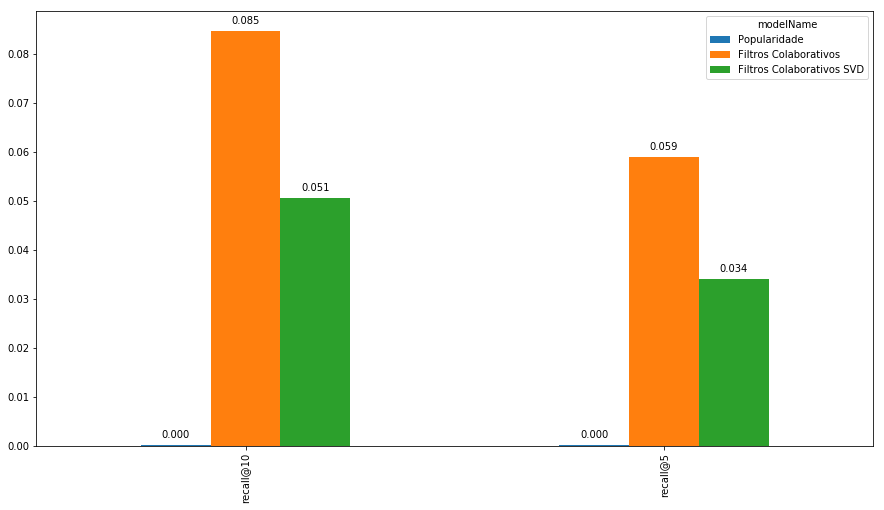

In [55]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Conclusão

Nesse notebook, eu explorei os modelos de recomendação baseados na popularidade, que pode ainda ser bastante efetivos em casos de usuários novos, que ainda não tem histórico, mas que se mostra pouco acertivo com relação a personlização da recomendação. Tambem apresentei um segundo modelo, baseado nas interações de grupos de usuários semelhantes, esse modelo nesse caso foi o que teve a melhor acurária, para os dados de teste. O terceiro modelo foi baseado na fatoração de matrizes com SVD, é um modelo bastante poderoso, mas que se mostrou menos efetivo quando aplicado em uma matriz muito esparça que foi o nosso caso.

Tentei resolver o problema da matriz esparça removendo da base as recomendações iguais a zero, não resolveu muito nesse caso. Acredito que a outra alternativa seria considera a média das avaliação do livro para as avaliação faltantes ou com zero. Ou tambem mudar a abordagem, considerando a própria interação com o livro (compra, visualização na loja virtual, etc) como uma operação válida para recomendação do produto.